In [20]:
# %pip install tensorflow gpflow

In [21]:
print('hello world')

hello world


In [22]:
# %pip install tensorflow --upgrade

In [23]:
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from gpflow.kernels import Matern32
from gpflow.models import GPR
from gpflow import set_trainable
from sklearn.preprocessing import StandardScaler
import vectorbt as vbt


def fetch_and_process_data(
    ticker="BTC-USD", start_date="2024-01-01", end_date="2024-12-31"
):
    # Download data
    data = yf.download(ticker, start=start_date, end=end_date)

    # Calculate returns and standardize
    close = data["Adj Close"]
    returns = close.pct_change().dropna()
    scaler = StandardScaler()
    std_returns = scaler.fit_transform(returns.values.reshape(-1, 1))

    return close[returns.index], pd.Series(std_returns.flatten(), index=returns.index)


def generate_signals(returns, train_ratio=0.8, epochs=50):
    # Prepare features
    X = np.arange(len(returns), dtype=np.float64).reshape(-1, 1)
    y = returns.values.reshape(-1, 1)

    # GPR for trend detection
    kernel = Matern32()
    gpr = GPR(data=(X, y), kernel=kernel)
    set_trainable(gpr.likelihood.variance, False)
    trend = gpr.predict_f(X)[0].numpy().flatten()

    # Combine returns + trend as features
    features = np.hstack([returns.values.reshape(-1, 1), trend.reshape(-1, 1)])

    # Train/test split
    split_index = int(len(features) * train_ratio)
    train_features = features[:split_index]
    test_features = features[split_index:]

    train_labels = returns.values[:split_index]
    test_labels = returns.values[split_index:]

    # Reshape for LSTM
    train_features = train_features.reshape(
        (train_features.shape[0], 1, train_features.shape[1])
    )
    test_features = test_features.reshape(
        (test_features.shape[0], 1, test_features.shape[1])
    )

    # Build LSTM model
    model = Sequential(
        [
            LSTM(
                64,
                return_sequences=True,
                input_shape=(train_features.shape[1], train_features.shape[2]),
            ),
            Dropout(0.2),
            LSTM(32),
            Dense(1, activation="tanh"),
        ]
    )
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")

    # Fit the model (using next-day return as a rough training signal)
    model.fit(train_features, train_labels, epochs=epochs, batch_size=32, verbose=0)

    # Predict signals for all data (train + test)
    all_features = features.reshape((features.shape[0], 1, features.shape[1]))
    predicted_signals = model.predict(all_features).flatten()

    # Convert continuous signals to [-1, 1] range
    positions = np.clip(predicted_signals, -1, 1)
    return positions


def backtest_strategy(close, positions):
    # Convert positions to entry/exit signals
    positions = pd.Series(positions, index=close.index)
    entries = positions > 0
    exits = positions < 0

    # Create portfolio
    pf = vbt.Portfolio.from_signals(
        close=close, entries=entries, exits=exits, size=np.abs(positions), freq="1D"
    )

    return pf


def main():
    # Get data
    close, returns = fetch_and_process_data()

    # Generate trading signals (configure epochs as desired)
    positions = generate_signals(returns, train_ratio=0.8, epochs=50)

    # Run backtest
    portfolio = backtest_strategy(close, positions)

    # Print key metrics
    print("\nPortfolio Metrics:")
    print(f"Total Return: {portfolio.total_return():.2%}")
    print(f"Sharpe Ratio: {portfolio.sharpe_ratio():.2f}")
    print(f"Max Drawdown: {portfolio.max_drawdown():.2%}")

    # Plot results
    portfolio.plot().show()
    
    print(portfolio.stats())


if __name__ == "__main__":
    main()

[*********************100%%**********************]  1 of 1 completed
/Users/Chega/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Portfolio Metrics:
Total Return: 50.00%
Sharpe Ratio: 1.34
Max Drawdown: -25.38%


Start                               2024-01-02 00:00:00
End                                 2024-12-30 00:00:00
Period                                364 days 00:00:00
Start Value                                       100.0
End Value                                    150.004092
Total Return [%]                              50.004092
Benchmark Return [%]                         106.066274
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              25.379407
Max Drawdown Duration                 213 days 00:00:00
Total Trades                                         94
Total Closed Trades                                  94
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  37.234043
Best Trade [%]                                26.811372
Worst Trade [%]                               -6

[*********************100%%**********************]  1 of 1 completed


Epoch 1/30


/Users/Chega/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: -0.5472  
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.6157
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.6306
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.6884
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.6110
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.5940
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.6420
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.6359
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.6287
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.6347
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.6165
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.6141
Epoch 13/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.5965
Epoch 14/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.6159
Epoch 15/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.6374
Epoch 16/30
1

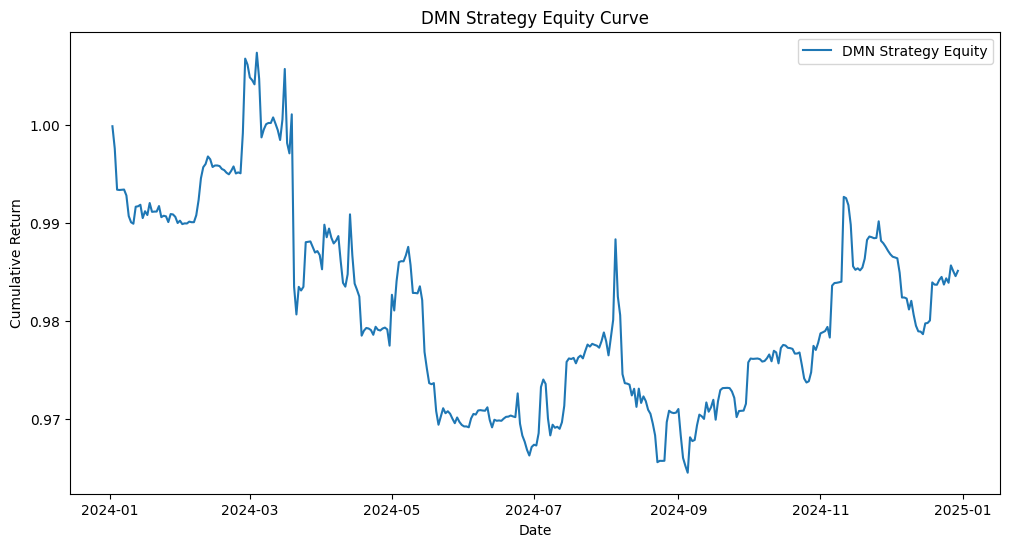

In [24]:
import numpy as np
import pandas as pd
import yfinance as yf
import gpflow
from gpflow.utilities import set_trainable
from gpflow.models import GPR
from gpflow.kernels import Matern32
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


# ------------------------------------------------------
# 1. Data Preprocessing
# ------------------------------------------------------
def fetch_data(ticker="AAPL", start="2020-01-01", end="2021-12-31"):
    """
    Fetch historical price data from Yahoo Finance, then compute daily returns
    and standardize them. Extract momentum indicators to form a feature set.
    """
    data = yf.download(ticker, start=start, end=end)
    data.dropna(inplace=True)

    # Compute daily returns
    data["Returns"] = data["Adj Close"].pct_change().fillna(0.0)

    # Simple momentum indicator (e.g., 10-day rolling return)
    data["Momentum_10"] = data["Adj Close"].pct_change(periods=10).fillna(0.0)
    data["Momentum_20"] = data["Adj Close"].pct_change(periods=20).fillna(0.0)

    # Standardize numeric columns except 'Adj Close'
    scaler = StandardScaler()
    feature_cols = ["Returns", "Momentum_10", "Momentum_20"]
    data[feature_cols] = scaler.fit_transform(data[feature_cols])

    # Drop any rows with NaNs that might remain
    data.dropna(inplace=True)

    return data


# ------------------------------------------------------
# 2. Changepoint Detection (CPD) using Gaussian Processes
# ------------------------------------------------------
def detect_changepoints(features):
    """
    Fits a Gaussian Process (GP) model to detect changepoints in the feature data.
    For simplicity, this function focuses on a single feature (e.g., Returns).
    In practice, you could expand this to multi-dimensional CPD.
    """
    X = np.arange(len(features)).reshape(-1, 1).astype(float)
    y = features.values.reshape(-1, 1).astype(float)

    # Define a Matern 3/2 kernel
    kernel = Matern32()
    gpr_model = GPR(data=(X, y), kernel=kernel, mean_function=None)

    # Typically, we may fix the likelihood variance for stable GP estimation
    set_trainable(gpr_model.likelihood.variance, False)

    # Optimize the GP hyperparameters
    opt = gpflow.optimizers.Scipy()
    opt.minimize(
        gpr_model.training_loss,
        variables=gpr_model.trainable_variables,
        options=dict(maxiter=50),
    )

    # Predict the function mean which we can interpret as a "trend" or baseline
    mean, var = gpr_model.predict_f(X)

    # Convert the EagerTensor to a NumPy array, then flatten
    mean_np = mean.numpy()
    # A simple changepoint "severity" measure: gradient magnitude or variance
    # Here, as a placeholder, we use the absolute difference of the predicted mean
    cp_severity = np.abs(np.diff(mean_np.flatten(), prepend=mean_np[0]))

    return mean_np.flatten(), cp_severity


# ------------------------------------------------------
# 3. Deep Momentum Network (DMN) with an LSTM
#    - Optimizing for Sharpe ratio
# ------------------------------------------------------
def custom_sharpe_loss(y_true, y_pred):
    """
    Custom loss function approximating negative Sharpe ratio.
    y_pred: predicted position sizes
    y_true: actual returns (or some target based on returns).
    """
    # Safe epsilon to avoid division by zero
    eps = 1e-9

    # Calculate portfolio returns = predicted_position * actual_return
    portfolio_returns = y_pred * y_true
    mean_return = tf.reduce_mean(portfolio_returns)
    std_return = tf.math.reduce_std(portfolio_returns) + eps

    # We minimize negative Sharpe ratio => -(mean / std)
    return -(mean_return / std_return)


def build_dmn(input_shape):
    """
    Builds an LSTM-based model (DMN) that outputs position sizes (between -1 and 1).
    """
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dense(1, activation="tanh"))  # Position range [-1, 1]
    # Use a custom loss approximating negative Sharpe ratio
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=custom_sharpe_loss
    )
    return model


# ------------------------------------------------------
# 4. Backtesting
# ------------------------------------------------------
def backtest_strategy(prices, positions):
    """
    Simplified backtest using daily returns and position sizes.
    positions: array or Series of DMN outputs in [-1, 1].
    """
    df = pd.DataFrame(index=prices.index)
    df["Price"] = prices
    df["Position"] = positions

    # Calculate daily returns
    df["Return"] = df["Price"].pct_change().fillna(0.0)
    # Strategy returns = position * daily returns
    df["Strategy_Return"] = df["Position"].shift(1) * df["Return"]

    # Cumulative growth of 1 dollar
    df["Cumulative"] = (1 + df["Strategy_Return"]).cumprod()

    return df


# ------------------------------------------------------
# 5. Evaluation Metrics
# ------------------------------------------------------
def evaluate_performance(df):
    """
    Compute performance metrics including annualized return, volatility,
    Sharpe ratio, Sortino ratio, and maximum drawdown.
    """
    daily_returns = df["Strategy_Return"]
    annual_factor = 252  # Approx. trading days in a year

    # Annualized Return
    ann_return = (1 + daily_returns.mean()) ** annual_factor - 1

    # Annualized Volatility
    ann_vol = daily_returns.std() * np.sqrt(annual_factor)

    # Sharpe Ratio
    sharpe_ratio = (ann_return - 0.0) / (ann_vol if ann_vol != 0 else 1e-9)

    # Sortino Ratio (using downside std)
    negative_returns = daily_returns[daily_returns < 0]
    downside_std = negative_returns.std() * np.sqrt(annual_factor)
    sortino_ratio = (ann_return - 0.0) / (downside_std if downside_std != 0 else 1e-9)

    # Maximum Drawdown
    cum_returns = (1 + daily_returns).cumprod()
    peak = cum_returns.cummax()
    drawdowns = (cum_returns - peak) / peak
    max_drawdown = drawdowns.min()

    print("Performance Metrics:")
    print(f"Annualized Return: {ann_return:.2%}")
    print(f"Annualized Volatility: {ann_vol:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Sortino Ratio: {sortino_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")


# ------------------------------------------------------
# Main Execution
# ------------------------------------------------------
def main():
    # 1. Data Preprocessing
    data = fetch_data(ticker="BTC-USD", start="2024-01-01", end="2024-12-31")

    # Target feature for CPD (e.g., standardized returns)
    returns_feature = data["Returns"]

    # 2. Changepoint Detection
    trend, cp_severity = detect_changepoints(returns_feature)

    # Add CPD outputs as new features
    data["Trend"] = trend
    # Smoothing or scaling of cp_severity might help
    data["CP_Severity"] = cp_severity

    # 3. Build and Train DMN
    # Prepare feature set for DMN: returns, momentum, CPD, etc.
    feature_cols = ["Returns", "Momentum_10", "Momentum_20", "Trend", "CP_Severity"]
    X = data[feature_cols].values
    y = data["Returns"].values  # Using returns as a training signal

    # Reshape for LSTM: (batch_size, time_steps=1, input_dim=len(feature_cols))
    X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))

    model = build_dmn(input_shape=(1, X.shape[1]))
    model.fit(X_reshaped, y, epochs=30, batch_size=32, verbose=1)

    # Generate signals (predicted position sizes)
    positions = model.predict(X_reshaped).flatten()

    # 4. Backtest
    backtest_df = backtest_strategy(data["Adj Close"], positions)

    # 5. Evaluate Performance
    evaluate_performance(backtest_df)

    # Plot the equity curve
    plt.figure(figsize=(12, 6))
    plt.plot(backtest_df.index, backtest_df["Cumulative"], label="DMN Strategy Equity")
    plt.title("DMN Strategy Equity Curve")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.show()


if __name__ == "__main__":
    main()

In [25]:
import numpy as np
import pandas as pd
import yfinance as yf
import gpflow
from gpflow.utilities import set_trainable
from gpflow.models import GPR
from gpflow.kernels import Matern32
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import vectorbt as vbt


# ------------------------------------------------------
# 1. Data Preprocessing
# ------------------------------------------------------
def fetch_data(ticker="AAPL", start="2020-01-01", end="2021-12-31"):
    """
    Fetch historical price data from Yahoo Finance, then compute daily returns
    and standardize them. Extract momentum indicators to form a feature set.
    """
    data = yf.download(ticker, start=start, end=end)
    data.dropna(inplace=True)

    # Compute daily returns
    data["Returns"] = data["Adj Close"].pct_change().fillna(0.0)

    # Simple momentum indicator (e.g., 10-day rolling return)
    data["Momentum_10"] = data["Adj Close"].pct_change(periods=10).fillna(0.0)
    data["Momentum_20"] = data["Adj Close"].pct_change(periods=20).fillna(0.0)

    # Standardize numeric columns except 'Adj Close'
    scaler = StandardScaler()
    feature_cols = ["Returns", "Momentum_10", "Momentum_20"]
    data[feature_cols] = scaler.fit_transform(data[feature_cols])

    # Drop any rows with NaNs that might remain
    data.dropna(inplace=True)

    return data


# ------------------------------------------------------
# 2. Changepoint Detection (CPD) using Gaussian Processes
# ------------------------------------------------------
def detect_changepoints(features):
    """
    Fits a Gaussian Process (GP) model to detect changepoints in the feature data.
    For simplicity, this function focuses on a single feature (e.g., Returns).
    In practice, you could expand this to multi-dimensional CPD.
    """
    X = np.arange(len(features)).reshape(-1, 1).astype(float)
    y = features.values.reshape(-1, 1).astype(float)

    # Define a Matern 3/2 kernel
    kernel = Matern32()
    gpr_model = GPR(data=(X, y), kernel=kernel, mean_function=None)

    # Typically, we may fix the likelihood variance for stable GP estimation
    set_trainable(gpr_model.likelihood.variance, False)

    # Optimize the GP hyperparameters
    opt = gpflow.optimizers.Scipy()
    opt.minimize(
        gpr_model.training_loss,
        variables=gpr_model.trainable_variables,
        options=dict(maxiter=50),
    )

    # Predict the function mean which we can interpret as a "trend" or baseline
    mean, var = gpr_model.predict_f(X)

    # Convert the EagerTensor to a NumPy array, then flatten
    mean_np = mean.numpy()
    # A simple changepoint "severity" measure: gradient magnitude or variance
    # Here, we use the absolute difference of the predicted mean as a placeholder
    cp_severity = np.abs(np.diff(mean_np.flatten(), prepend=mean_np[0]))

    return mean_np.flatten(), cp_severity


# ------------------------------------------------------
# 3. Deep Momentum Network (DMN) with an LSTM
#    - Optimizing for Sharpe ratio
# ------------------------------------------------------
def custom_sharpe_loss(y_true, y_pred):
    """
    Custom loss function approximating negative Sharpe ratio.
    y_pred: predicted position sizes
    y_true: actual returns (or some target based on returns).
    """
    # Safe epsilon to avoid division by zero
    eps = 1e-9

    # Calculate portfolio returns = predicted_position * actual_return
    portfolio_returns = y_pred * y_true
    mean_return = tf.reduce_mean(portfolio_returns)
    std_return = tf.math.reduce_std(portfolio_returns) + eps

    # We minimize negative Sharpe ratio => -(mean / std)
    return -(mean_return / std_return)


def build_dmn(input_shape):
    """
    Builds an LSTM-based model (DMN) that outputs position sizes (between -1 and 1).
    """
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dense(1, activation="tanh"))  # Position range [-1, 1]
    # Use a custom loss approximating negative Sharpe ratio
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=custom_sharpe_loss
    )
    return model


# ------------------------------------------------------
# 4. VectorBT Backtesting Integration
# ------------------------------------------------------
def backtest_with_vectorbt(prices, positions):
    """
    Backtest the DMN signals using vectorbt's Portfolio.from_signals.
    We interpret positions > 0 as buys, positions < 0 as sells.
    The absolute value of the position determines the size.
    """
    # Convert positions array to a Pandas Series with the same index as prices
    positions_series = pd.Series(positions, index=prices.index)

    # Generate entry (positions > 0) and exit (positions < 0) signals
    entries = positions_series > 0
    exits = positions_series < 0

    # Build the portfolio
    # size=np.abs(positions) for partial positions if needed
    portfolio = vbt.Portfolio.from_signals(
        close=prices,
        entries=entries,
        exits=exits,
        size=np.abs(positions_series),
        freq="1D",
    )

    return portfolio


# ------------------------------------------------------
# Main Execution
# ------------------------------------------------------
def main():
    # 1. Data Preprocessing
    data = fetch_data(ticker="BTC-USD", start="2020-01-01", end="2024-12-31")

    # Target feature for CPD (e.g., standardized returns)
    returns_feature = data["Returns"]

    # 2. Changepoint Detection
    trend, cp_severity = detect_changepoints(returns_feature)

    # Add CPD outputs as new features
    data["Trend"] = trend
    data["CP_Severity"] = cp_severity

    # 3. Build and Train DMN
    # Prepare feature set for DMN: returns, momentum, CPD, etc.
    feature_cols = ["Returns", "Momentum_10", "Momentum_20", "Trend", "CP_Severity"]
    X = data[feature_cols].values
    y = data["Returns"].values  # Using returns as a training signal

    # Reshape for LSTM: (batch_size, time_steps=1, input_dim=len(feature_cols))
    X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))

    model = build_dmn(input_shape=(1, X.shape[1]))
    model.fit(X_reshaped, y, epochs=30, batch_size=32, verbose=1)

    # Generate signals (predicted position sizes)
    positions = model.predict(X_reshaped).flatten()

    # Use vectorbt for backtesting
    portfolio = backtest_with_vectorbt(data["Adj Close"], positions)

    # Print key metrics from vectorbt
    print("\nVectorBT Performance Metrics:")
    print(f"Total Return: {portfolio.total_return():.2%}")
    print(f"Sharpe Ratio: {portfolio.sharpe_ratio():.2f}")
    print(f"Max Drawdown: {portfolio.max_drawdown():.2%}")

    # Plot the equity curve
    portfolio.plot().show()

    print(portfolio.stats())

if __name__ == "__main__":
    main()

[*********************100%%**********************]  1 of 1 completed


Epoch 1/30


/Users/Chega/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step - loss: -0.4076
Epoch 2/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: -0.5009
Epoch 3/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: -0.5658
Epoch 4/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: -0.5406
Epoch 5/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: -0.5658
Epoch 6/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: -0.5462
Epoch 7/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: -0.5599
Epoch 8/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: -0.6135
Epoch 9/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: -0.6056
Epoch 10/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: -0.6428
Epoch 11/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: -0.6836
Epoch 12/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: -0.6954
Epoch 13/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: -0.7361
Epoch 14/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: -0.7791
Epoch 15/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step -

Start                               2020-01-01 00:00:00
End                                 2024-12-30 00:00:00
Period                               1826 days 00:00:00
Start Value                                       100.0
End Value                                    227.859495
Total Return [%]                             127.859495
Benchmark Return [%]                        1186.680112
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              60.710336
Max Drawdown Duration                1373 days 00:00:00
Total Trades                                        471
Total Closed Trades                                 471
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  40.127389
Best Trade [%]                                24.854946
Worst Trade [%]                              -13